In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys

ROOT_PATH = os.path.dirname(os.getcwd())
sys.path.append(ROOT_PATH)
try:
    sys.path.remove('/projects/p30802/Karina/protease_stability/')
except:
    pass

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

from src_.evals.run_model import run_model, build_model, get_params
from src_.evals.data_processing import get_and_process_data, get_folded_unfolded_data_splits
from src_.utils.general import multi_target_train_test_split, average_losses, sample_arrays
from src_.models.wrapper import ProtNet
from tensorflow.keras import optimizers
from src_.config import Config
from src_.evals.stability_score import plot_stability_score_correlation

_____

### Custom Config

In [2]:
DATA_PATH = os.path.join(ROOT_PATH, "data/210728_scrambles_for_unstructure_model.csv")
DATA2_PATH = os.path.join(ROOT_PATH, "data/210728_dmsv2_alldata.csv")

In [4]:
MODEL_TYPE = "convnet_1d"

_____

### Prepare data

In [14]:
X_unfolded, kT_unfolded, kC_unfolded = get_and_process_data(DATA_PATH, fit_to_range="clip")
X_folded, kT_folded, kC_folded = get_and_process_data(DATA2_PATH, fit_to_range="remove")

In [22]:
unfolded_data, folded_data = get_folded_unfolded_data_splits(X_unfolded, kT_unfolded, kC_unfolded,
                                                            X_folded, kT_folded, kC_folded)

_____

### Train the model

In [23]:
params, epochs = get_params(MODEL_TYPE)

params["num_char"] = Config.get("n_char")
params["seq_length"] = Config.get("seq_length")

In [27]:
model = ProtNet(model_type = MODEL_TYPE, **params)

In [28]:
model.train(
    X_unfolded=unfolded_data["X_train"],
    kT_unfolded=unfolded_data["kT_train"],
    kC_unfolded=unfolded_data["kC_train"],
    X_folded=folded_data["X_train"],
    kT_folded=folded_data["kT_train"],
    kC_folded=folded_data["kC_train"],
    epochs=epochs,
)


Epoch 1/8:

	step=0:   loss=17.988,   unfolded_mse=34.362,   stab_score_agreement_mse=1.613
	val_loss=17.842,   val_unfolded_mse=33.881,   val_stab_score_agreement_mse=1.803

	step=50:   loss=16.642,   unfolded_mse=31.456,   stab_score_agreement_mse=1.829
	val_loss=16.985,   val_unfolded_mse=32.75,   val_stab_score_agreement_mse=1.219

	step=100:   loss=17.852,   unfolded_mse=34.462,   stab_score_agreement_mse=1.242
	val_loss=17.087,   val_unfolded_mse=32.941,   val_stab_score_agreement_mse=1.233

	step=150:   loss=16.059,   unfolded_mse=31.028,   stab_score_agreement_mse=1.091
	val_loss=16.94,   val_unfolded_mse=32.653,   val_stab_score_agreement_mse=1.227

	step=200:   loss=16.672,   unfolded_mse=32.152,   stab_score_agreement_mse=1.192
	val_loss=17.018,   val_unfolded_mse=32.814,   val_stab_score_agreement_mse=1.223

	step=250:   loss=18.628,   unfolded_mse=36.137,   stab_score_agreement_mse=1.118
	val_loss=17.029,   val_unfolded_mse=32.838,   val_stab_score_agreement_mse=1.22

	st

_____

### Plot losses

In [29]:
# Retrieve losses
loss, unfolded_mse, agreement_mse = \
    model.losses["loss"], model.losses["unfolded_mse"], model.losses["agreement_mse"]

val_loss, val_unfolded_mse, val_agreement_mse = \
    model.losses["val_loss"], model.losses["val_unfolded_mse"], model.losses["val_agreement_mse"]

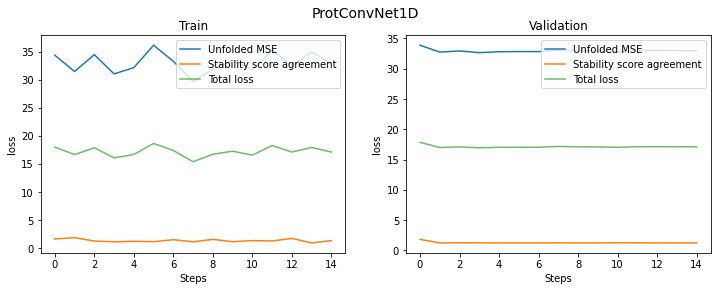

In [30]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(unfolded_mse, label="Unfolded MSE")
ax.plot(agreement_mse, label="Stability score agreement")
ax.plot(loss, label="Total loss", alpha = 0.7)
ax.set_xlabel("Steps")
ax.set_ylabel("loss")
ax.set_title("Train")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(val_unfolded_mse, label="Unfolded MSE")
ax.plot(val_agreement_mse, label="Stability score agreement")
ax.plot(val_loss, label="Total loss", alpha = 0.7)
ax.set_xlabel("Steps")
ax.set_ylabel("loss")
ax.set_title("Validation")
ax.legend()


plt.suptitle(model.model.name.replace("_", " "), fontsize=14)
plt.show()

### Plot stability scores

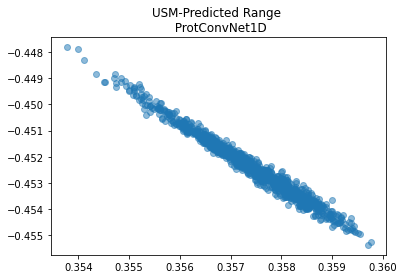

In [35]:
X_test_folded_samples = sample_arrays([folded_data["X_test"]], n_samples=1000)[0]

kT_pred, kC_pred = model.predict(X_test_folded_samples)

title=model.model.name.replace("_", " ")
plt.scatter(kT_pred, kC_pred, alpha=0.5)
plt.title(f"USM-Predicted Range \n {title}")
plt.show()

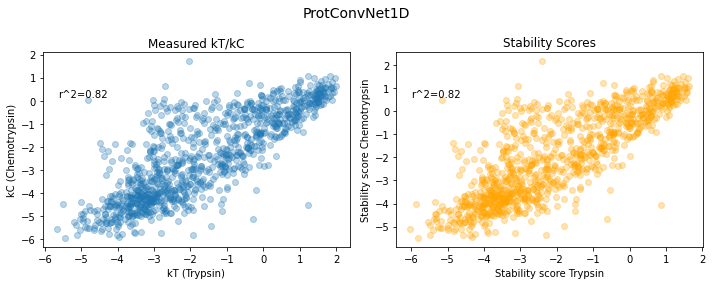

In [36]:
np.random.seed(42)
plot_stability_score_correlation(model.model,
                                 folded_data["X_test"],
                                 folded_data["kT_test"],
                                 folded_data["kC_test"],
                                 sample = 1000)

#### Local stability scores

In [196]:
data_folded = pd.read_csv(DATA2_PATH)
data_folded["pdb_code"] =  [name.split(".")[0] for name in data_folded.name]
grouped_indices = data_folded.groupby(by="pdb_code").indices

In [197]:
X, kT, kC = get_and_process_data(DATA2_PATH, return_as_df=True)

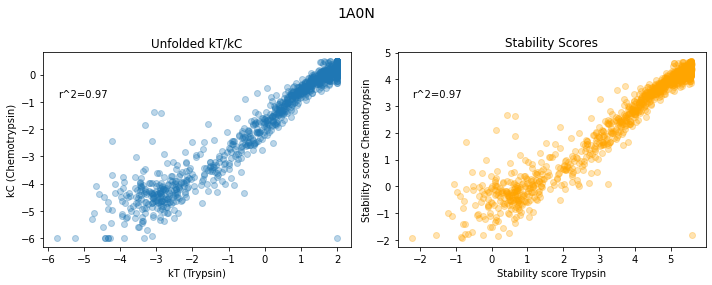

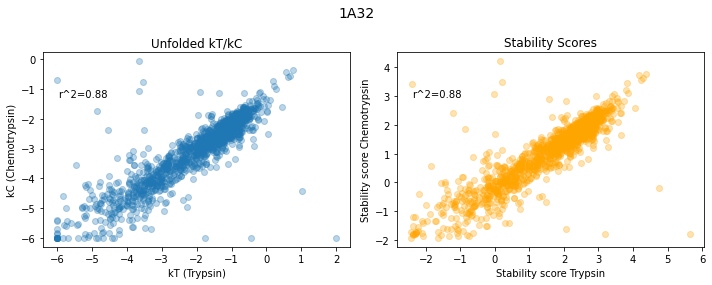

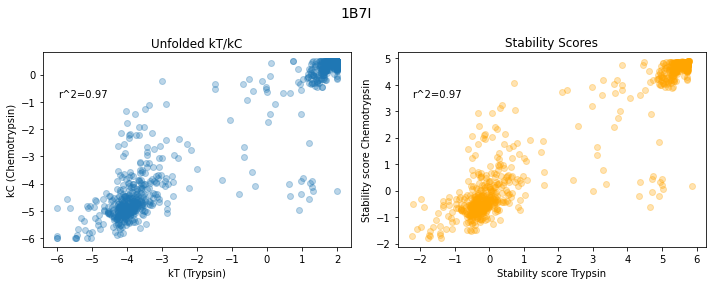

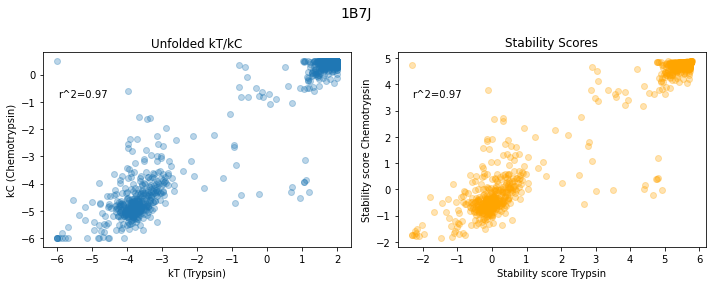

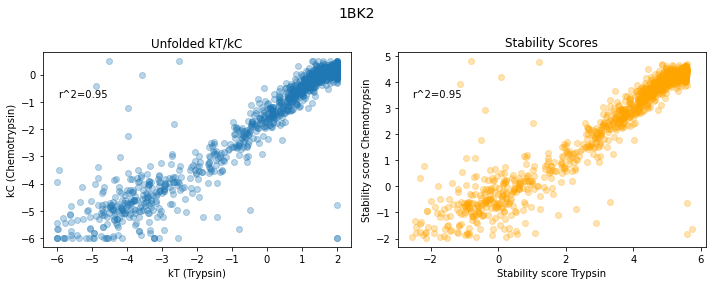

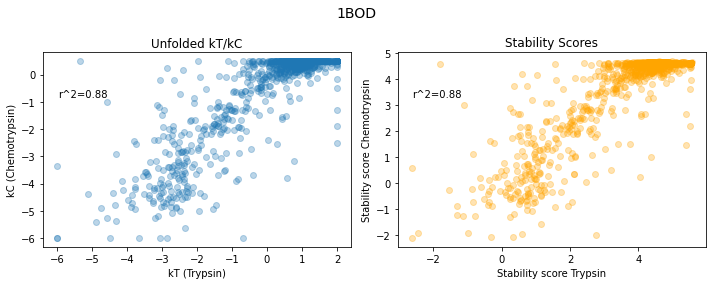

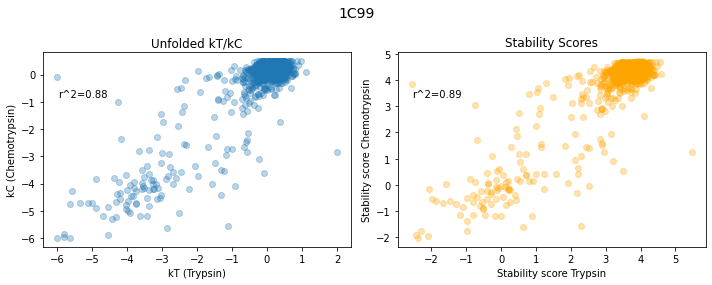

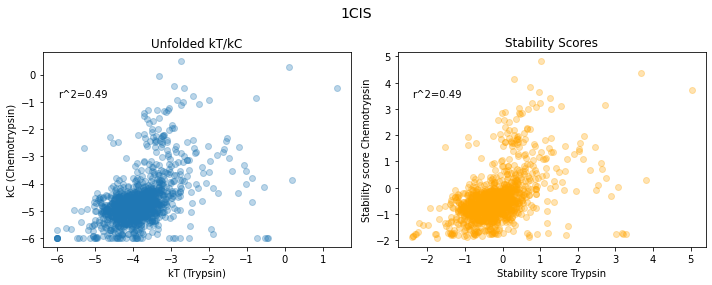

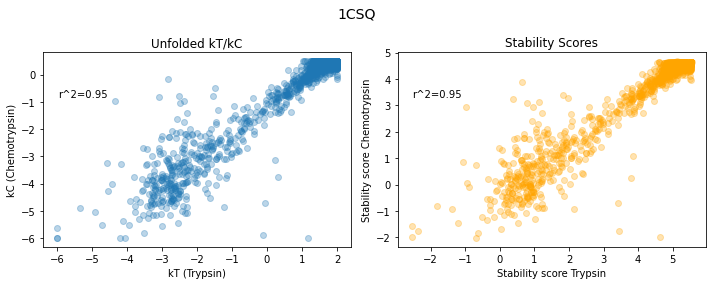

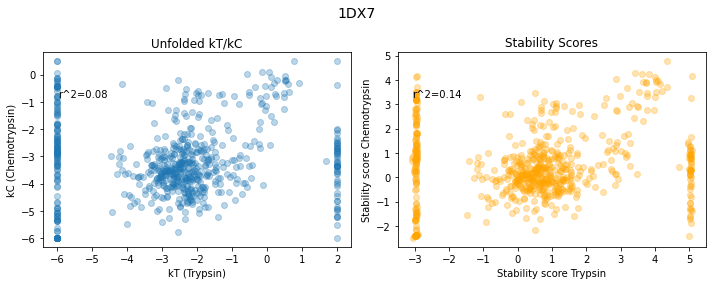

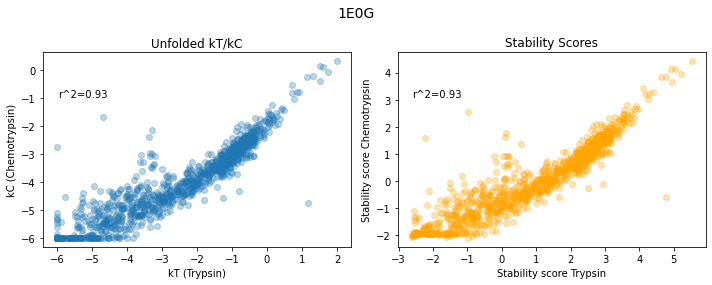

In [198]:
save = False
n_to_plot = 20
save_dir = save_path = os.path.join(ROOT_PATH, f"results/stability_scores/{MODEL_TYPE}/mutations/")


if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i, (group_name, indices) in enumerate(grouped_indices.items()):
    if len(indices) > 10:
        X_, kT_, kC_ = X.loc[indices], kT.loc[indices], kC.loc[indices]
        kT_, kC_ = np.array(kT_), np.array(kC_)
        
        save_path = os.path.join(save_dir, f"{group_name}.png")

        if save:   
            plot_stability_score_correlation(model.model, X_, kT_, kC_, title=group_name, save_path = save_path)
        else:
            plot_stability_score_correlation(model.model, X_, kT_, kC_, title=group_name)

    if i == n_to_plot:
        break

_____

_____